<a href="https://colab.research.google.com/github/Akechi1412/Phishing-Website-Detection/blob/main/app/notebooks/data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prepare data for Phishing Webpage Detection Model**

## **Connect to Drive and Github responsitory**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github
%cd Phishing-Website-Detection/app
!git config --global user.email "nguyenphong10042002@gmail.com"
!git config --global user.name "Akechi1412"
!git fetch origin
!git reset --hard origin/main

/content/drive/MyDrive/Github
/content/drive/MyDrive/Github/Phishing-Website-Detection/app
Updating files: 100% (15/15), done.
HEAD is now at b011c64 Merge branch 'main' of https://github.com/Akechi1412/Phishing-Website-Detection


## **Load data**

In [3]:
!pip install aiohttp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.9/208.9 kB 9.1 MB/s eta 0:00:00


In [4]:
from utils.data_preparing import load_data
from utils.data_preprocessing import parse_html
import gc

In [5]:
data_size = 50000
data_train, data_val, data_test = load_data(data_size=data_size)

In [6]:
print(len(data_train), len(data_val), len(data_test))
print(data_train[0].keys())

80000 10000 10000
dict_keys(['url', 'html', 'label'])


In [7]:
# Extracting train data
url_train = [item['url'] for item in data_train]
html_train = [item['html'] for item in data_train]
label_train = [item['label'] for item in data_train]

# Extracting validation data
url_val = [item['url'] for item in data_val]
html_val = [item['html'] for item in data_val]
label_val = [item['label'] for item in data_val]

# Extracting test data
url_test = [item['url'] for item in data_test]
html_test = [item['html'] for item in data_test]
label_test = [item['label'] for item in data_test]

In [8]:
del data_train, data_val, data_test
gc.collect()

0

## **Create word-based URL representation**

In [9]:
from utils.data_preprocessing import split_url, build_dictionary, transform_url
from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Text(0, 0.5, 'Frequency (Number of URLs)')

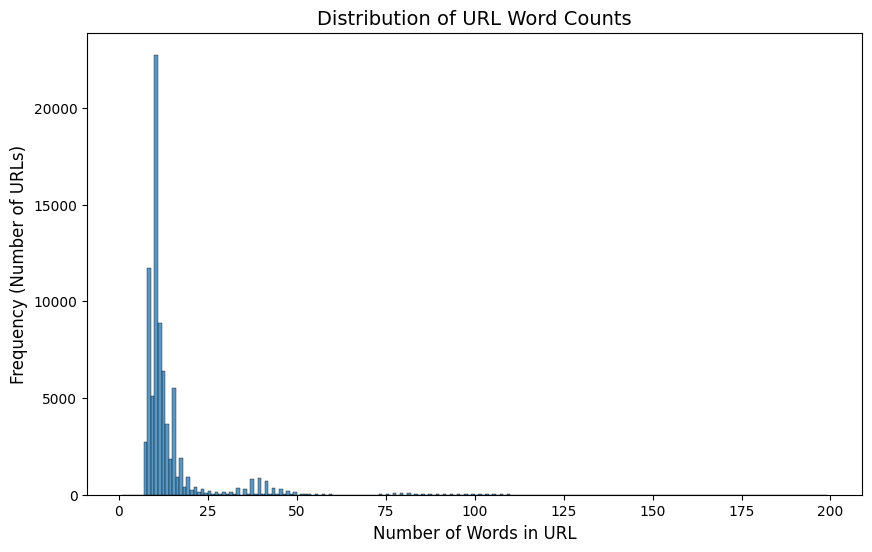

In [10]:
word_counts = [len(split_url(url)) for url in url_train]
plt.figure(figsize=(10, 6))
sns.histplot(word_counts, bins=range(1, 200), kde=False)
plt.title('Distribution of URL Word Counts', fontsize=14)
plt.xlabel('Number of Words in URL', fontsize=12)
plt.ylabel('Frequency (Number of URLs)', fontsize=12)

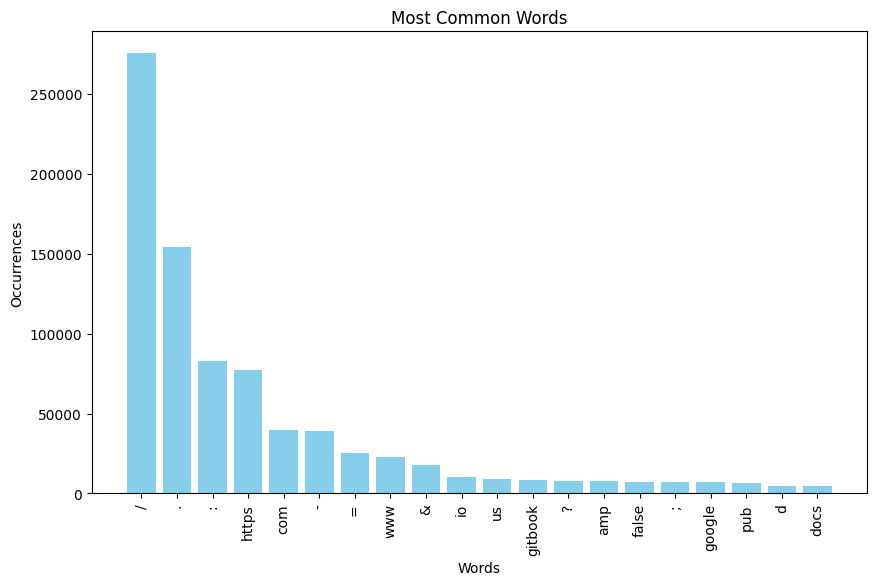

Number of words appearing more 2 times: 5415


In [11]:
words = [word for url in url_train for word in split_url(url)]
word_counts = Counter(words)
common_words = {word: count for word, count in word_counts.items() if count > 2}
most_common_words = Counter(common_words).most_common(20)

labels, values = zip(*most_common_words)

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='skyblue')
plt.xlabel("Words")
plt.ylabel("Occurrences")
plt.title("Most Common Words")
plt.xticks(rotation=90)
plt.show()

num_common_words = len(common_words)
print("Number of words appearing more 2 times:", num_common_words)

In [12]:
max_word = 50
vocab_size = 6000

filename = 'models/dictionary.pkl'
dictionary = build_dictionary(words, vocab_size=vocab_size, filename=filename)

url_train = np.array([transform_url(url, dictionary, max_word=max_word) for url in url_train])
url_val = np.array([transform_url(url, dictionary, max_word=max_word) for url in url_val])
url_test = np.array([transform_url(url, dictionary, max_word=max_word) for url in url_test])

Dictionary saved to models/dictionary.pkl


In [13]:
print(url_train[0])

[21  3  1  1  0  2  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]


## **Create graph-based HTML DOM representation**

In [14]:
from utils.data_preprocessing import parse_html, create_graph, create_graph_adjacency, create_graph_feature
import numpy as np
from concurrent.futures import ProcessPoolExecutor

In [15]:
def count_nodes(html):
    dom_tree = parse_html(html)
    graph = create_graph(dom_tree)
    return len(graph.nodes())

def statistic_nodes(htmls, max_workers=4):
    node_counts = []
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        node_counts = list(executor.map(count_nodes, html_train))
    return node_counts

Text(0, 0.5, 'Frequency (Number of HTMLs)')

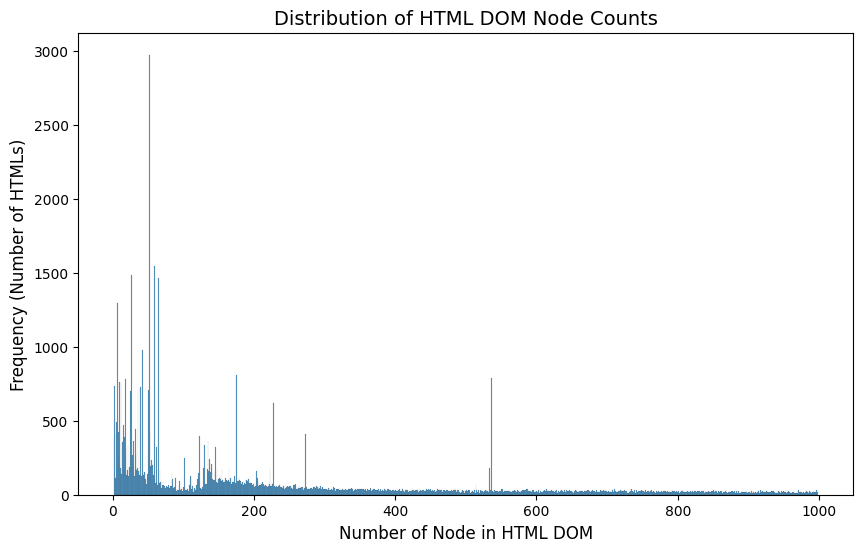

In [16]:
node_counts = statistic_nodes(html_train, max_workers=12)
plt.figure(figsize=(10, 6))
sns.histplot(node_counts, bins=range(1, 1000), kde=False)
plt.title('Distribution of HTML DOM Node Counts', fontsize=14)
plt.xlabel('Number of Node in HTML DOM', fontsize=12)
plt.ylabel('Frequency (Number of HTMLs)', fontsize=12)

In [17]:
def process_html(html, max_node):
    dom_tree = parse_html(html)
    graph = create_graph(dom_tree)
    adjacency = create_graph_adjacency(graph, max_node=max_node)
    feature = create_graph_feature(graph, max_node=max_node)
    return adjacency, feature

def process_htmls(htmls, max_node, max_workers=4):
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        results = list(executor.map(process_html, htmls, [max_node] * len(htmls)))

    adjacencies = np.array([result[0] for result in results])
    features = np.array([result[1] for result in results])

    return adjacencies, features

In [18]:
max_node = 400

adjacency_train, feature_train = process_htmls(html_train, max_node=max_node, max_workers=12)
adjacency_val, feature_val = process_htmls(html_val, max_node=max_node, max_workers=12)
adjacency_test, feature_test = process_htmls(html_test, max_node=max_node, max_workers=12)

In [19]:
print(adjacency_train.shape, feature_train.shape)
print(adjacency_val.shape, feature_val.shape)
print(adjacency_test.shape, feature_test.shape)

(80000, 400, 400) (80000, 400, 3)
(10000, 400, 400) (10000, 400, 3)
(10000, 400, 400) (10000, 400, 3)


## **Save train, val and test data**

In [20]:
import h5py

In [21]:
label_train = np.array(label_train)
label_val = np.array(label_val)
label_test = np.array(label_test)

with h5py.File('data/train.h5', 'w') as f:
    f.create_dataset('url', data=url_train, compression='gzip')
    f.create_dataset('adjacency', data=adjacency_train, compression='gzip')
    f.create_dataset('feature', data=feature_train, compression='gzip')
    f.create_dataset('label', data=label_train, compression='gzip')

with h5py.File('data/val.h5', 'w') as f:
    f.create_dataset('url', data=url_val, compression='gzip')
    f.create_dataset('adjacency', data=adjacency_val, compression='gzip')
    f.create_dataset('feature', data=feature_val, compression='gzip')
    f.create_dataset('label', data=label_val, compression='gzip')

with h5py.File('data/test.h5', 'w') as f:
    f.create_dataset('url', data=url_test, compression='gzip')
    f.create_dataset('adjacency', data=adjacency_test, compression='gzip')
    f.create_dataset('feature', data=feature_test, compression='gzip')
    f.create_dataset('label', data=label_test, compression='gzip')